In [40]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import graphviz
import json
from pandas.io.json import json_normalize

In [26]:
def cleanData(filePath, filePathJson, encoding):
    data = pd.read_csv(filePath, encoding=encoding)
    data['trending_date'] = '20' + data['trending_date']
    data['trending_date'] = pd.to_datetime(data['trending_date'],format='%Y.%d.%m')
    data['publish_time'] = data['publish_time'].replace(regex=True,to_replace=r"T.*",value=r'')
    data['publish_time'] = pd.to_datetime(data['publish_time'],format='%Y-%m-%d', errors='coerce')
    categories = pd.read_json(filePathJson)
    catData = json_normalize(categories['items'])
    idToCategories = pd.DataFrame(columns=['category_id', 'category'])
    idToCategories['category_id'] = catData['id']
    idToCategories['category'] = catData['snippet.title']
    idToCategories['category_id'] = idToCategories['category_id'].astype('int64')
    myData = pd.merge(data, idToCategories)
    myData = myData.drop(columns='category_id')
    myData['tags'] = myData.tags.str.strip().str.lower().str.replace('"','').str.replace('|',',')
    myData = myData.drop_duplicates()
    return myData

def allParcableCountryData():
    us = cleanData('../Data/Youtube/USvideos.csv', '../Data/Youtube/US_category_id.json', "latin_1")
    mx=  cleanData('../Data/Youtube/MXvideos.csv', '../Data/Youtube/MX_category_id.json', "latin_1")
    ca=  cleanData('../Data/Youtube/CAvideos.csv', '../Data/Youtube/CA_category_id.json', "latin_1")
    de=  cleanData('../Data/Youtube/DEvideos.csv', '../Data/Youtube/DE_category_id.json', "latin_1")
    gb=  cleanData('../Data/Youtube/GBvideos.csv', '../Data/Youtube/GB_category_id.json', "latin_1")
    ind= cleanData('../Data/Youtube/INvideos.csv', '../Data/Youtube/IN_category_id.json', "latin_1")
    fr=  cleanData('../Data/Youtube/FRvideos.csv', '../Data/Youtube/FR_category_id.json', "latin_1")
    us["country"] = "us"
    mx["country"] = "mx"
    ca["country"] = "ca"
    de["country"] = "de"
    gb["country"] = "gb"
    ind["country"] = "in"
    fr["country"] = "fr"
    data = us.append([mx,ca,de,gb,ind,fr])
    return data

In [27]:
allData = allParcableCountryData()

In [17]:
groupedData = allData.groupby('country')

Text(0.5, 1.0, 'Number of views by country')

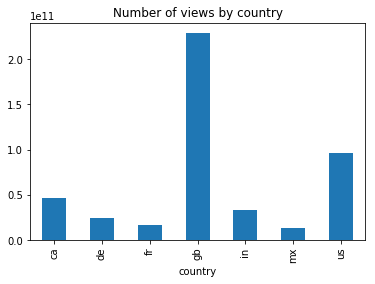

In [5]:
groupedData.views.sum().plot.bar()
plt.title('Number of views by country')

Text(0.5, 1.0, 'Number of likes by country')

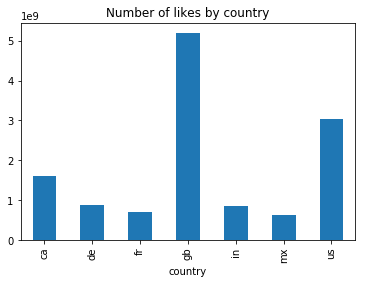

In [6]:
groupedData.likes.sum().plot.bar()
plt.title('Number of likes by country')

Text(0.5, 1.0, 'Number of dislikes by country')

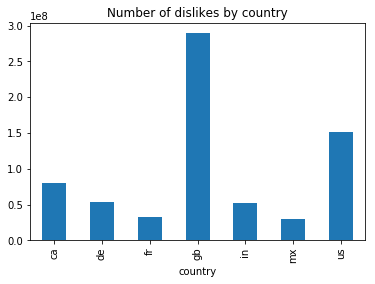

In [7]:
groupedData.dislikes.sum().plot.bar()
plt.title('Number of dislikes by country')

Text(0.5, 1.0, 'Number of entries by country')

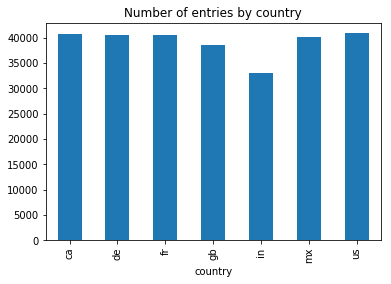

In [8]:
groupedData.count().title.plot.bar()
plt.title('Number of entries by country')

Text(0.5, 1.0, 'Number of comment count by country')

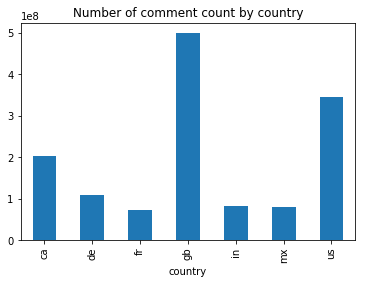

In [9]:
groupedData.comment_count.sum().plot.bar()
plt.title('Number of comment count by country')

In [28]:
allData['trending'] = pd.qcut(allData.views,q=2,labels=['Not Trending','Trending'])
allData.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,country,trending
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13,shantell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,us,Trending


In [20]:
attributes = allData.drop(['channel_title','views','likes','dislikes','comment_count','trending','video_id','thumbnail_link','trending_date','publish_time','description','country'],axis=1)

In [21]:
attributes.title = [len(title.split()) for title in attributes.title]

In [22]:
attributes.tags = [len(tag.split()) for tag in attributes.tags]

In [23]:
attributes = pd.get_dummies(attributes)

In [24]:
attributes.head(4)

,title,tags,comments_disabled,ratings_disabled,video_error_or_removed,category_Autos & Vehicles,category_Comedy,category_Education,category_Entertainment,category_Film & Animation,...,category_Music,category_News & Politics,category_Nonprofits & Activism,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Shows,category_Sports,category_Trailers,category_Travel & Events
0,7,2,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,1,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,13,24,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,10,1,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [25]:
target = allData.trending
target.head(2)

0        Trending
1    Not Trending
Name: trending, dtype: category
Categories (2, object): [Not Trending < Trending]

In [26]:
target.value_counts()

Not Trending    137348
Trending        137345
Name: trending, dtype: int64

In [27]:
NBayes = MultinomialNB()

In [56]:
parameters={'alpha':range(1,15)}

In [57]:
NBayesCV = GridSearchCV(NBayes, param_grid=parameters)

In [58]:
NBayesCV.fit(attributes,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': range(10, 60)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

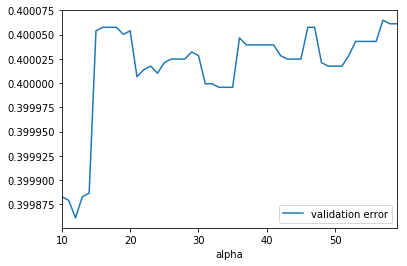

In [59]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

In [60]:
NBayesCV.best_params_

{'alpha': 12}

In [61]:
NBayesCV.best_score_

0.6001390643372784

In [62]:
error_rate = 1 - NBayesCV.best_score_
print('Naive Bayes error rate is ', error_rate.round(2))

Naive Bayes error rate is  0.4


In [41]:
Tree = tree.DecisionTreeClassifier()

In [49]:
parameters = {'max_depth':range(27,50)} # define a dictionary

In [50]:
TreeCV = GridSearchCV(Tree,param_grid=parameters,return_train_score=True) # cross validation

In [51]:
TreeCV.fit(attributes,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(27, 50)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

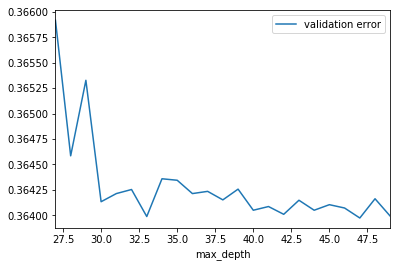

In [52]:
error = pd.DataFrame()
error['max_depth'] = parameters['max_depth']
error['validation error'] = 1 - TreeCV.cv_results_['mean_test_score']
error.plot.line(x='max_depth',y='validation error')

In [53]:
TreeCV.best_params_

{'max_depth': 47}

In [54]:
TreeCV.best_score_

0.6360264003815168

In [55]:
error_rate = 1 - TreeCV.best_score_
print('Decision Tree classifaier error rate is ', error_rate.round(2))

Decision Tree classifaier error rate is  0.36


# NLP Classifer

In [79]:
allData.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,country,trending
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13,shantell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,us,Trending


## Title

In [95]:
tfidfVectorizer_1 = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidfVectorizer_2 = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tfidfVectorizer_3 = TfidfVectorizer(analyzer='word', ngram_range=(1,3))

In [96]:
tfidf_1 = tfidfVectorizer_1.fit_transform(allData.title.values)
tfidf_2 = tfidfVectorizer_2.fit_transform(allData.title.values)
tfidf_3 = tfidfVectorizer_3.fit_transform(allData.title.values)

In [97]:
vocab_1 = tfidfVectorizer_1.get_feature_names()
vocab_1 = pd.Series(vocab_1)
vocab_2 = tfidfVectorizer_2.get_feature_names()
vocab_2 = pd.Series(vocab_2)
vocab_3 = tfidfVectorizer_3.get_feature_names()
vocab_3 = pd.Series(vocab_3)

In [98]:
important_words_1 = np.asarray(tfidf_1.sum(axis=0)).flatten()
important_words_2 = np.asarray(tfidf_2.sum(axis=0)).flatten()
important_words_3 = np.asarray(tfidf_3.sum(axis=0)).flatten()

In [99]:
important_words_1 = pd.Series(important_words_1,index=vocab_1)
print(important_words_1.sort_values(ascending=False).head())
print('----------------------------')
important_words_2 = pd.Series(important_words_2,index=vocab_2)
print(important_words_2.sort_values(ascending=False).head())
print('----------------------------')
important_words_3 = pd.Series(important_words_3,index=vocab_3)
print(important_words_3.sort_values(ascending=False).head())

the         5154.474828
2018        4376.161713
de          4003.383097
official    3433.850995
¾à          3218.490386
dtype: float64
----------------------------
the         3163.513415
2018        2688.524002
de          2444.862289
¾à          2233.256306
official    2199.880175
dtype: float64
----------------------------
the         2500.010729
2018        2099.224802
de          1908.032287
¾à          1793.589604
official    1752.591258
dtype: float64


In [100]:
attributes_1 = tfidf_1
attributes_2 = tfidf_2
attributes_3 = tfidf_3
target = allData.trending

In [101]:
NBayes = MultinomialNB()

In [102]:
parameters={'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]}#np.arange(1,14)/1000000

In [103]:
NBayesCV_1 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_2 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_3 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)

In [104]:
NBayesCV_1.fit(attributes_1,target)
NBayesCV_2.fit(attributes_2,target)
NBayesCV_3.fit(attributes_3,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

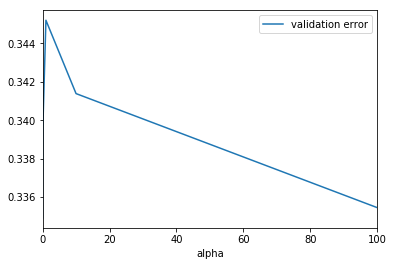

In [105]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_1.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

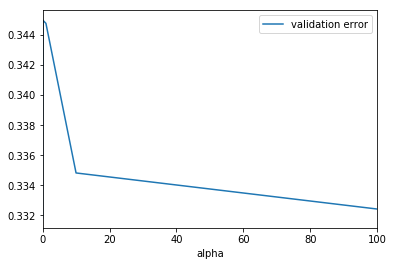

In [106]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_2.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

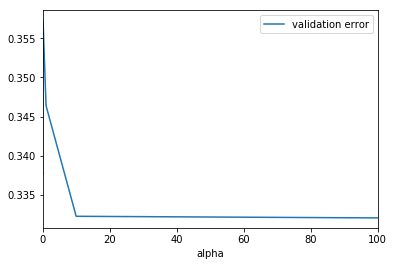

In [107]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_3.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

In [108]:
print('best params: ',NBayesCV_1.best_params_)
print('validation error: ',1-NBayesCV_1.best_score_)
print('training error: ',1- NBayesCV_1.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_2.best_params_)
print('validation error: ',1-NBayesCV_2.best_score_)
print('training error: ',1- NBayesCV_2.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_3.best_params_)
print('validation error: ',1-NBayesCV_3.best_score_)
print('training error: ',1- NBayesCV_3.cv_results_['mean_train_score'].max())
print('-----------------------------------------------------')
print('baseline error: ',1- (target.value_counts().max()/target.shape[0]))

best params:  {'alpha': 1e-06}
validation error:  0.33491934632480624
training error:  0.12702725881936905
---------------------------------------------------------
best params:  {'alpha': 1e-06}
validation error:  0.3318286232266566
training error:  0.05409130450008537
---------------------------------------------------------
best params:  {'alpha': 100}
validation error:  0.33207253188104535
training error:  0.04677950083818161
-----------------------------------------------------
baseline error:  0.4999945393584838


## Tags

In [109]:
tfidfVectorizer_1 = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidfVectorizer_2 = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tfidfVectorizer_3 = TfidfVectorizer(analyzer='word', ngram_range=(1,3))

In [110]:
tfidf_1 = tfidfVectorizer_1.fit_transform(allData.tags.values)
tfidf_2 = tfidfVectorizer_2.fit_transform(allData.tags.values)
tfidf_3 = tfidfVectorizer_3.fit_transform(allData.tags.values)

In [111]:
vocab_1 = tfidfVectorizer_1.get_feature_names()
vocab_1 = pd.Series(vocab_1)
vocab_2 = tfidfVectorizer_2.get_feature_names()
vocab_2 = pd.Series(vocab_2)
vocab_3 = tfidfVectorizer_3.get_feature_names()
vocab_3 = pd.Series(vocab_3)

In [112]:
important_words_1 = np.asarray(tfidf_1.sum(axis=0)).flatten()
important_words_2 = np.asarray(tfidf_2.sum(axis=0)).flatten()
important_words_3 = np.asarray(tfidf_3.sum(axis=0)).flatten()

In [113]:
important_words_1 = pd.Series(important_words_1,index=vocab_1)
print(important_words_1.sort_values(ascending=False).head())
print('----------------------------')
important_words_2 = pd.Series(important_words_2,index=vocab_2)
print(important_words_2.sort_values(ascending=False).head())
print('----------------------------')
important_words_3 = pd.Series(important_words_3,index=vocab_3)
print(important_words_3.sort_values(ascending=False).head())

none    23071.393413
the      3457.476442
news     2929.736853
2018     2784.820647
de       2548.083124
dtype: float64
----------------------------
none    23071.241501
the      2280.554420
news     1999.779709
2018     1910.849127
de       1694.862818
dtype: float64
----------------------------
none    23071.192141
the      1853.376068
news     1638.507173
2018     1584.446182
de       1373.935582
dtype: float64


In [114]:
attributes_1 = tfidf_1
attributes_2 = tfidf_2
attributes_3 = tfidf_3
target = allData.trending

In [115]:
attributes.shape

(274693, 101863)

In [116]:
NBayes = MultinomialNB()

In [117]:
parameters={'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]}#np.arange(1,14)/1000000

In [118]:
NBayesCV_1 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_2 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_3 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_1.fit(attributes_1,target)
NBayesCV_2.fit(attributes_2,target)
NBayesCV_3.fit(attributes_3,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

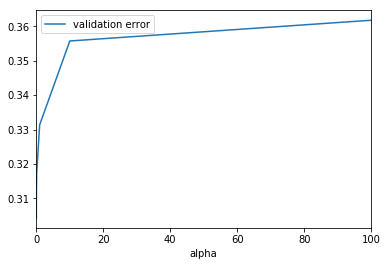

In [119]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_1.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

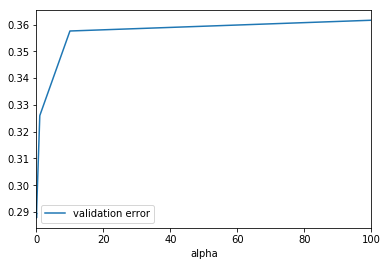

In [120]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_2.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

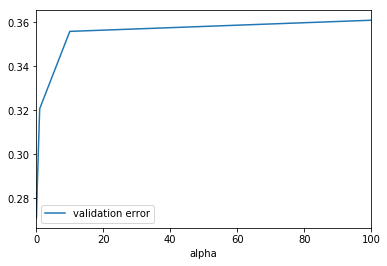

In [121]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_3.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

In [122]:
print('best params: ',NBayesCV_1.best_params_)
print('validation error: ',1-NBayesCV_1.best_score_)
print('training error: ',1- NBayesCV_1.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_2.best_params_)
print('validation error: ',1-NBayesCV_2.best_score_)
print('training error: ',1- NBayesCV_2.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_3.best_params_)
print('validation error: ',1-NBayesCV_3.best_score_)
print('training error: ',1- NBayesCV_3.cv_results_['mean_train_score'].max())
print('-----------------------------------------------------')
print('baseline error: ',1- (target.value_counts().max()/target.shape[0]))

best params:  {'alpha': 1e-05}
validation error:  0.30433975383428047
training error:  0.125085099108602
---------------------------------------------------------
best params:  {'alpha': 0.01}
validation error:  0.2877830887572672
training error:  0.07741916521679393
---------------------------------------------------------
best params:  {'alpha': 0.01}
validation error:  0.2710262001579946
training error:  0.07276669669675595
-----------------------------------------------------
baseline error:  0.4999945393584838


### Channel Title

In [123]:
tfidfVectorizer_1 = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidfVectorizer_2 = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tfidfVectorizer_3 = TfidfVectorizer(analyzer='word', ngram_range=(1,3))

In [124]:
tfidf_1 = tfidfVectorizer_1.fit_transform(allData.channel_title.values)
tfidf_2 = tfidfVectorizer_2.fit_transform(allData.channel_title.values)
tfidf_3 = tfidfVectorizer_3.fit_transform(allData.channel_title.values)

In [125]:
vocab_1 = tfidfVectorizer_1.get_feature_names()
vocab_1 = pd.Series(vocab_1)
vocab_2 = tfidfVectorizer_2.get_feature_names()
vocab_2 = pd.Series(vocab_2)
vocab_3 = tfidfVectorizer_3.get_feature_names()
vocab_3 = pd.Series(vocab_3)

In [126]:
important_words_1 = np.asarray(tfidf_1.sum(axis=0)).flatten()
important_words_2 = np.asarray(tfidf_2.sum(axis=0)).flatten()
important_words_3 = np.asarray(tfidf_3.sum(axis=0)).flatten()

In [127]:
important_words_1 = pd.Series(important_words_1,index=vocab_1)
print(important_words_1.sort_values(ascending=False).head())
print('----------------------------')
important_words_2 = pd.Series(important_words_2,index=vocab_2)
print(important_words_2.sort_values(ascending=False).head())
print('----------------------------')
important_words_3 = pd.Series(important_words_3,index=vocab_3)
print(important_words_3.sort_values(ascending=False).head())

tv      3566.278725
the     3530.514550
news    2514.631152
show    1556.474844
with    1349.145189
dtype: float64
----------------------------
tv       2556.559586
the      2484.095056
news     1797.926943
show     1071.936525
music     966.069759
dtype: float64
----------------------------
tv       2466.227755
the      2232.537140
news     1750.137798
show      932.116492
music     917.150062
dtype: float64


In [128]:
attributes_1 = tfidf_1
attributes_2 = tfidf_2
attributes_3 = tfidf_3
target = allData.trending

In [129]:
NBayes = MultinomialNB()

In [130]:
parameters={'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]}#np.arange(1,14)/1000000

In [131]:
NBayesCV_1 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_2 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_3 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_1.fit(attributes_1,target)
NBayesCV_2.fit(attributes_2,target)
NBayesCV_3.fit(attributes_3,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

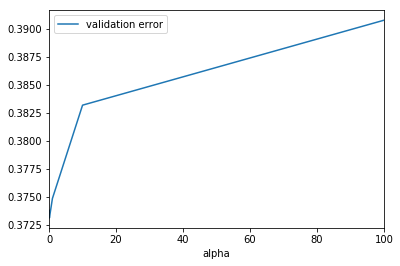

In [132]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_1.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

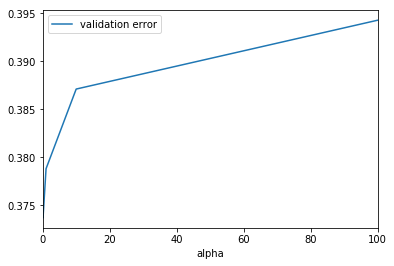

In [133]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_2.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

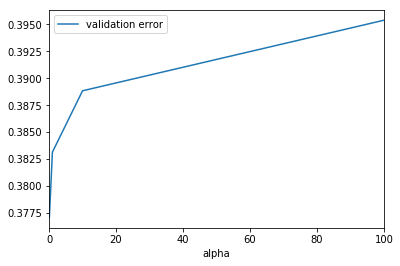

In [134]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_3.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

In [135]:
print('best params: ',NBayesCV_1.best_params_)
print('validation error: ',1-NBayesCV_1.best_score_)
print('training error: ',1- NBayesCV_1.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_2.best_params_)
print('validation error: ',1-NBayesCV_2.best_score_)
print('training error: ',1- NBayesCV_2.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_3.best_params_)
print('validation error: ',1-NBayesCV_3.best_score_)
print('training error: ',1- NBayesCV_3.cv_results_['mean_train_score'].max())
print('-----------------------------------------------------')
print('baseline error: ',1- (target.value_counts().max()/target.shape[0]))

best params:  {'alpha': 0.1}
validation error:  0.37313655608260854
training error:  0.1322348945017473
---------------------------------------------------------
best params:  {'alpha': 0.1}
validation error:  0.37368262023422516
training error:  0.12014503336959803
---------------------------------------------------------
best params:  {'alpha': 0.01}
validation error:  0.3770500158358604
training error:  0.11969179966652721
-----------------------------------------------------
baseline error:  0.4999945393584838


### Title + channel title + tags

In [150]:
mixedColumns = allData.title + ' ' + allData.channel_title + ' ' + allData.tags

In [151]:
mixedColumns.head(2)

0    WE WANT TO TALK ABOUT OUR MARRIAGE CaseyNeista...
1     Me-O Cats Commercial Nobrand cute,cats,thai,eggs
dtype: object

In [152]:
tfidfVectorizer_1 = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidfVectorizer_2 = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tfidfVectorizer_3 = TfidfVectorizer(analyzer='word', ngram_range=(1,3))
tfidf_1 = tfidfVectorizer_1.fit_transform(mixedColumns.values)
tfidf_2 = tfidfVectorizer_2.fit_transform(mixedColumns.values)
tfidf_3 = tfidfVectorizer_3.fit_transform(mixedColumns.values)
vocab_1 = tfidfVectorizer_1.get_feature_names()
vocab_1 = pd.Series(vocab_1)
vocab_2 = tfidfVectorizer_2.get_feature_names()
vocab_2 = pd.Series(vocab_2)
vocab_3 = tfidfVectorizer_3.get_feature_names()
vocab_3 = pd.Series(vocab_3)
important_words_1 = np.asarray(tfidf_1.sum(axis=0)).flatten()
important_words_2 = np.asarray(tfidf_2.sum(axis=0)).flatten()
important_words_3 = np.asarray(tfidf_3.sum(axis=0)).flatten()
important_words_1 = pd.Series(important_words_1,index=vocab_1)
print(important_words_1.sort_values(ascending=False).head())
print('----------------------------')
important_words_2 = pd.Series(important_words_2,index=vocab_2)
print(important_words_2.sort_values(ascending=False).head())
print('----------------------------')
important_words_3 = pd.Series(important_words_3,index=vocab_3)
print(important_words_3.sort_values(ascending=False).head())

the     4414.233074
de      3667.444051
2018    3420.790443
none    3265.942392
news    2612.775552
dtype: float64
----------------------------
the     2903.167545
de      2370.481369
2018    2303.911000
none    1944.936510
news    1786.765732
dtype: float64
----------------------------
the     2362.384624
de      1896.073264
2018    1888.546095
none    1515.214666
news    1466.420396
dtype: float64


In [153]:
attributes_1 = tfidf_1
attributes_2 = tfidf_2
attributes_3 = tfidf_3
target = allData.trending
NBayes = MultinomialNB()
parameters={'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]}#np.arange(1,14)/1000000
NBayesCV_1 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_2 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_3 = GridSearchCV(NBayes, param_grid=parameters, return_train_score=True)
NBayesCV_1.fit(attributes_1,target)
NBayesCV_2.fit(attributes_2,target)
NBayesCV_3.fit(attributes_3,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

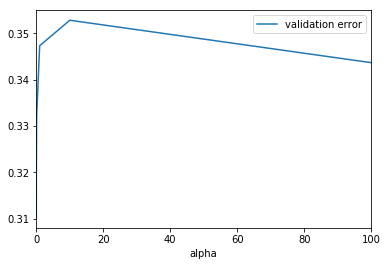

In [155]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_1.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

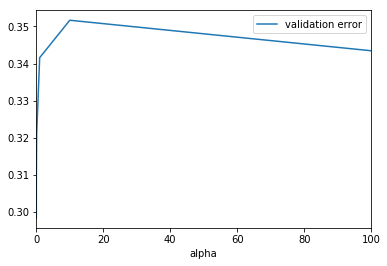

In [156]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_2.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

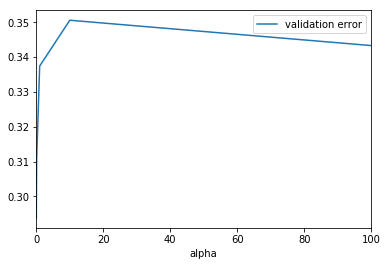

In [157]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV_3.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

In [158]:
print('best params: ',NBayesCV_1.best_params_)
print('validation error: ',1-NBayesCV_1.best_score_)
print('training error: ',1- NBayesCV_1.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_2.best_params_)
print('validation error: ',1-NBayesCV_2.best_score_)
print('training error: ',1- NBayesCV_2.cv_results_['mean_train_score'].max())
print('---------------------------------------------------------')
print('best params: ',NBayesCV_3.best_params_)
print('validation error: ',1-NBayesCV_3.best_score_)
print('training error: ',1- NBayesCV_3.cv_results_['mean_train_score'].max())
print('-----------------------------------------------------')
print('baseline error: ',1- (target.value_counts().max()/target.shape[0]))

best params:  {'alpha': 1e-06}
validation error:  0.3101899211119322
training error:  0.10548139371932708
---------------------------------------------------------
best params:  {'alpha': 1e-06}
validation error:  0.2983257673111437
training error:  0.05021242234236567
---------------------------------------------------------
best params:  {'alpha': 1e-06}
validation error:  0.29384076041253326
training error:  0.044495127613423335
-----------------------------------------------------
baseline error:  0.4999945393584838
